## Семинар 4: "Сверточные сети"

ФИО: Дегтярев Роман Олегович

In [4]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from scipy.signal import convolve
from skimage import io, transform
from skimage.color import rgb2gray
from tqdm import tqdm
from PIL import Image
import copy
import random
from scipy.ndimage.filters import maximum_filter, median_filter, gaussian_filter
import torchvision.datasets as dset
%matplotlib inline

### Часть 1: Свертка

#### Одномерные сигналы
Начнем с одномерных сигналов — например, это могут быть различные временные ряды. 

<i>1.1 Реализуйте функцию, вычисляющую одномерную свертку.</i>

In [1]:
def t_convolve(signal, kernel):
    signal_convolved = np.zeros(len(signal)-len(kernel)+1)
    # 1. не забудьте перевернуть ядро!
    # 2. необходимо реализовать свертку без отступов, т.е. 
    #   размер результирующего сигнала должен быть меньше входного.
    
    ##### YOUR CODE HERE #####
    k = len(kernel)
    s = len(signal)
    kernel = kernel[::-1]
    ks = len(signal)-len(kernel)+1
    for i in range(0, ks):
        temp_sum =0
        for j in range(0,k):
                temp_sum +=signal[i+j]*kernel[j]
        signal_convolved[i] = temp_sum
    return signal_convolved

Проверим правильность реализации, сравнив с реализацией из scipy

In [94]:
from scipy.signal import convolve

signal = np.random.rand(100)
kernel = np.random.rand(5)
t_result = t_convolve(signal, kernel)
b_result = convolve(signal, kernel, mode='valid')

np.testing.assert_allclose(t_result, b_result)

Посмотрим как операция свертки может помочь нам убрать шум из сигнала

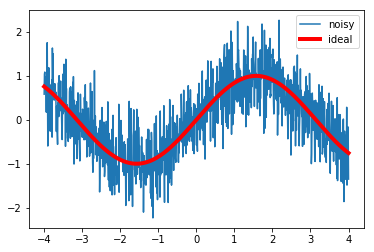

In [97]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.legend(loc=0)

Для подавления шума можно использовать усреднение значений сигнала в окрестности каждой точки (см. ЗБЧ). Вы можете убедиться, что такая операция может быть реализована при помощи свертки данных с ядром, $[\frac 1w, \frac 1w, ..., \frac 1w]$, где $w$ — размер окна.

<i>1.2  Вычислите свертку сигнала с ядром $[0.2, 0.2, 0.2, 0.2, 0.2]$ </i>

In [128]:
kernel = [0.2,0.2,0.2,0.2,0.2]
denoised_signal = t_convolve(signal, kernel)### YOUR CODE HERE #####

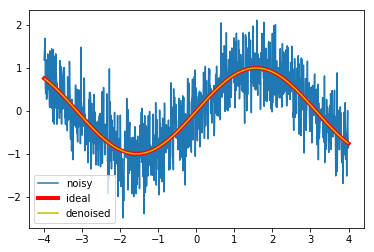

In [129]:
x = np.linspace(-4, 4, 1000)
signal = np.sin(x)
noisy_signal = signal + np.random.randn(signal.shape[0])*0.5
plt.plot(x, noisy_signal, label='noisy')
plt.plot(x, signal, 'r', label='ideal', linewidth=4)
plt.plot(x[2:-2], denoised_signal, 'y', label='denoised')
plt.legend(loc=0)

Заметим, что уровень шума значительно снизился! Попробуйте подобрать такую ширину окна, чтобы востановленный сигнал был наиболее похож на исходный.

<i> 1.3 Подберите размер окна <i>

In [ ]:
### YOUR CODE HERE #####
#kernel = [0.2,0.2,0.2,0.2,0.2] подходит

#### Многомерные сигналы
Перейдем теперь к черно-белым и цветным изображениям. Для ЧБ изображений имеем двумерный сигнал, для цветных — трехмерный (высота x ширина x каналы).

Для цветных изображений количество каналов ядра обычно совпадает с количеством каналов изображения. Таким образом, в результате получается черно-белое изображение.

<i>Для вычисления многомерных сверток используйте функцию convolve из from scipy.signal import convolve</i>

In [4]:
image = plt.imread('Lenna.png')

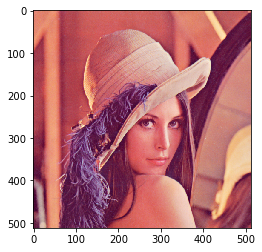

In [5]:
plt.imshow(image)

<i>1.4 Найдите в вашей любимой поисковой системе веса каналов для перевода цветного изображения в черно-белое. Постройте фильтр, который будет переводить цветное изображение в ЧБ</i>

In [76]:
def np_convert(img, coefs=np.array([0.299, 0.587, 0.114])):
    return np.dot(img[..., :3], coefs)
def cnv_convert(img, kernel = np.array([0.114,0.587,0.299])):
    kernel = kernel.reshape(1,1,-1)
    bw_image = convolve(kernel,image, mode='valid')
    print(bw_image.shape)
    return bw_image.reshape(bw_image.shape[0],bw_image.shape[1])

<i>1.5 На примере любого цветного изображения покажите результат его свертки с фильтром из предыдущего задания.</i>

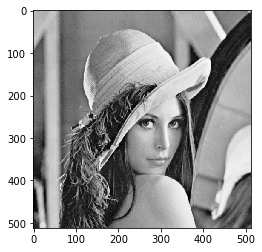

In [77]:
bw_image = np_convert(image) ##### YOUR CODE HERE #####
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

(512, 512, 1)


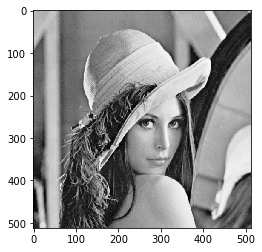

In [78]:
bw_image = cnv_convert(image)##### YOUR CODE HERE #####
# Не забудьте, что размер bw_image должен быть [w,h], а convolve вам вернет [w,h,1]
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

Операция свертки также позволяет находить границы на изображении. Для этого можно использовать, например, фильтр Собеля.

<i>1.6 Задайте ядро фильтра Собеля и продемонстрируйте результат его применения к любому цветному изображению.</i>

In [55]:
def my_sobel(img):
    sobel_kernel_h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]])
    sobel_kernel_v = np.transpose(sobel_kernel_h)

    # Step 2:
    # convolve img with these two filters
    conv_x = convolve(img,sobel_kernel_h)
    conv_y = convolve(img,sobel_kernel_v)

    # Step 3:
    # Compute edge: the map for the magnitude of gradient
    edge = np.sqrt(conv_x**2 + conv_y**2)

    return edge

In [56]:
img_gray = rgb2gray(image)

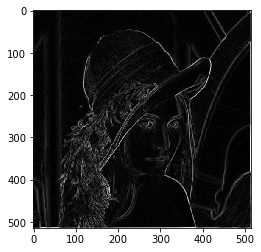

In [57]:
##### YOUR CODE HERE #####
bw_image = my_sobel(img_gray)
plt.imshow(bw_image, cmap="gray")
plt.show()

В сверточных нейронных сетях каждый слой использует несколько фильтров. Допустим, у нас было изображение с тремя каналами (количество входных каналов). Рассмотрим банк из четырех фильтров (количество выходных каналов). Тогда изначально будет вычислена свертка с каждым фильтром — получим 4 ЧБ изображения. Теперь соединим их в одно, интерпретируя каждое ЧБ изображение как канал цветного: RGB$\alpha$.

<i>1.7 Реализуйте операцию свертки с банком фильтров (filter bank).</i>

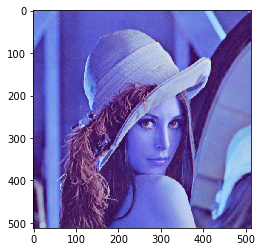

In [429]:
plt.imshow(image[...,::-1])

In [182]:
bank_filter = np.array(
      [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])

def t_convolve_bank(signal, kernel):
    assert signal.ndim == kernel.ndim+1
    ##### YOUR CODE HERE #####
    out = np.zeros((signal.shape[0],signal.shape[1], signal.ndim+1))
    out[...,0] = convolve(kernel[0].reshape(1,1,-1), signal, mode='valid').reshape(bw_image.shape[0],bw_image.shape[1])
    out[...,1] = convolve(signal, kernel[1].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0],bw_image.shape[1])
    out[...,2] = convolve(signal, kernel[2].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0],bw_image.shape[1])
    out[...,3] = convolve(signal, kernel[3].reshape(1,1,-1), mode='valid').reshape(bw_image.shape[0],bw_image.shape[1])
    return out

In [183]:
bgr = t_convolve_bank(image, bank_filter)

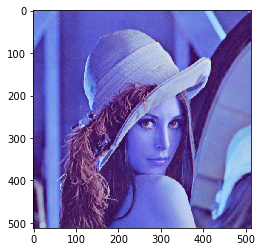

In [184]:
plt.imshow(bgr[...,[0,1,2]])

<i>1.8 Задайте банк фильтров, меняющий порядок следования каналов с RGB на BGR.</i>

In [180]:
RGB_BGR = np.array(
      [[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 0]])
#последний сделан, чтобы не ругался assert signal.ndim == kernel.ndim+1

<i>1.9 Продемонстрируйте результат свертки любого цветного изображения с банком фильтров из предыдущего пункта.</i>

In [280]:
#Можно попробовать что-то вроде этого:
GREY_RED_BLUE = np.array(
      [[-0.5,-1,-0.1],
       [0.1, 0.1, 0.1],
       [1,2,1],
       [0, 0, 0.5]])

In [281]:
somewhat = t_convolve_bank(image, GREY_RED_BLUE)

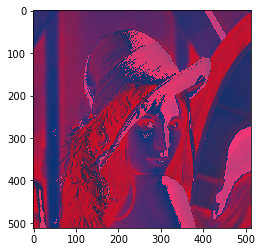

In [282]:
plt.imshow(somewhat[...,[0,1,3]])

In [ ]:
##### YOUR CODE HERE #####
# Не забудьте, что после свертки вы скорее всего получите тензор типа float. 
# Чтобы imshow нормально отобразил результат, надо привести его к типу uint8 (нпр., при помощи .astype('uint8'))

В процессе обучения сверточных нейронных сетей настраиваются веса элементов фильтр банка. Это позволяет не заниматься подбором коэффициентов "руками", а задавать лишь размер ядра: ширину, высоту, количество входных и выходных каналов. В итоге получаем четырехмерный массив (тензор).

### Часть 2: Пулинг

При использовании сверточных слоев принято использовать слои пулинга. Эта операция позволяет уменьшить пространственные размерности изображения и избавиться от избыточности.

<i>2.1 Реализуйте операции пулинга для цветных изображений</i>

In [86]:
def maxpool(img, window_size):
    assert(img.ndim == 3)
    ##### YOUR CODE HERE #####
    temp = copy.deepcopy(img)
    for i in range(0,img.ndim):
        a=temp[...,i]
        temp[...,i] = a*(a == maximum_filter(a,footprint=np.ones((window_size,window_size))))
    return temp

def medianpool(img,window_size):
    assert(img.ndim == 3)
    ##### YOUR CODE HERE #####
    temp = copy.deepcopy(img)
    for i in range(0,img.ndim):
        a=temp[...,i]
        temp[...,i] = a*(a == median_filter(a,footprint=np.ones((window_size,window_size))))
    return temp

Как и в первой части, посмотрим сначала как эта опреация влияет на цветные изображения.

<i>2.2 Взять цветное изображение и добавить к нему <a href="https://ru.wikipedia.org/wiki/Salt_and_pepper"> шум соль и перец</a>. Применить медианный пулинг и максимальный пулинг.</i>

In [87]:
def noisy(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.008
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisy = image + gauss
    return noisy

In [88]:
##### YOUR CODE HERE #####
image = plt.imread('Lenna.png')
noise = noisy(image)

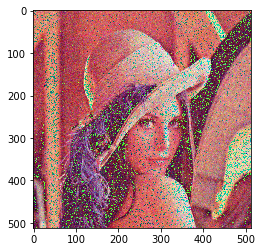

In [89]:
plt.imshow(noise)

Median Pooling & Max Pooling 


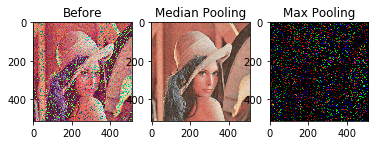

In [91]:
image = plt.imread('Lenna.png')
med_pool = median_filter(noise,3)
max_pool = maxpool(noise,3)

print("Median Pooling & Max Pooling ")
fig, (ax1,ax2,ax3) = plt.subplots(1,3)

ax1.set_title('Before')
ax1.imshow(noise)

ax2.set_title('Median Pooling')
ax2.imshow(med_pool)

ax3.set_title('Max Pooling')
ax3.imshow(max_pool)
plt.show()

<i>2.3 Какой тип пулинга лучше справился с поставленной задачей? Почему?</i>

In [92]:
#В медианном переходе чувствуется плавный переход от точке к точке, поэтому он все поправил

### Часть 3: Сверточная сеть на pyTorch

pyTorch предоставляет модули свертки и пулинга. Попробуем построить сеть и натренировать ее на данных MNIST. Для загрузки данных воспользуйтесь кодом со второго семинара.

Воспользуемся кодом с предыдущего семинара, чтобы обучить сверточную сеть на данных MNIST. Попробуем две архитектуры: 
2. input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
1. input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax

Здесь запись "c conv KxK" означает то, что на выходе должно получиться c каналов, а размер ядра — KxK

Ниже приведен пример сети. <i>(Документация: http://pytorch.org/docs/)</i>

In [5]:
#Параметры
batch_size = _batch_size = 10
learning_rate = _learning_rate = 0.01
num_epoch = _num_epoch = 10
keep_prob = 0.7

In [6]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [7]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          shuffle=False, 
                                          drop_last=True)

In [8]:
images_train, labels_train  = train_loader.dataset.train_data, train_loader.dataset.train_labels

In [9]:
images_train = images_train.resize_(6000,1, 28,28)

In [10]:
images_train.size()

torch.Size([6000, 1, 28, 28])

In [11]:
#  x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
#     x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)

In [12]:
# пример сверточной сети

#image_size = images_train.size(2)
channels = batch_size
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(1, 3, 3), nn.ReLU(), nn.MaxPool2d(2))
        self.linear_layers = nn.Sequential(nn.Linear((26)/2*(26)/2*3, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(batch_size, -1)
        x = self.linear_layers(x)
        return x

In [13]:
model = myConvNet()

In [14]:
# пример forward pass
network = myConvNet()
batch_size = 10
X = Variable(images_train[0:batch_size,:,::])
y = Variable(labels_train[:batch_size], requires_grad=False)


output = network.forward(X.float())

In [15]:
# а вот так можно сделать шаг обучения на этом батче
loss_fn = torch.nn.NLLLoss()

# о разных методах оптимизации мы поговорим на лекции 6
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 

loss = loss_fn(output, y)
print 'Current loss:', loss.data[0]

optimizer.zero_grad()
loss.backward()
optimizer.step()

Current loss: 35.5455207825


<i>3.1 Обучите сверточные сети с архитектурами (1) и (2). Какое качество удалось получить на тестовой выборке? Какой результат получался на полносвязной нейронной сети?</i>

In [2]:
##### YOUR CODE HERE #####
#input -> 8 conv 3x3 -> ReLU -> maxpool -> 16 conv 3x3 -> ReLU -> ravel -> linear -> softmax
class CNN_one(torch.nn.Module):
    def __init__(self):
        super(CNN_one, self).__init__()
        self.layer1 = torch.nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU(), nn.MaxPool2d(2))
        self.layer2 = torch.nn.Sequential(nn.Conv2d(8, 16, 3), nn.ReLU())
        self.layer3 = torch.nn.Sequential(nn.Linear((11)*(11)*16, 10), nn.LogSoftmax())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.view(batch_size, -1)
        x = self.layer3(x)
        return x  

## Формула для получения выходного изображения

$$W_{out} = (1 + \frac{W_{in}-Kernel\_size+2Padding}{Stride})*\frac{1}{MaxPool\_size}$$

Тут можно почитать более:
<a href="http://xrds.acm.org/blog/2016/06/convolutional-neural-networks-cnns-illustrated-explanation/">клик</a>

In [17]:
model = CNN_one()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=_learning_rate)

In [23]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

In [24]:
train_loader = torch.utils.data.DataLoader(mnist_train,
                                           batch_size=10,
                                           shuffle=True, 
                                           drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,
                                          batch_size=10,
                                          shuffle=False, 
                                          drop_last=True)

In [25]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = optimizer.param_groups[0]['lr'] * (0.1 ** (epoch // 30))
    optimizer.param_groups[0]['lr'] = lr

In [26]:
    _break_point = 0.01
    for i in range(1,_num_epoch):
        for j,[image,label] in enumerate(train_loader):
            x = Variable(image)
            y_= Variable(label)

            optimizer.zero_grad()
            output = model.forward(x)
            loss = loss_func(output,y_)
            loss.backward()
            adjust_learning_rate(optimizer, i)
            optimizer.step()
            if (loss.data.numpy()[0]<_break_point):
                break

            if j % 1000 == 0:
                print(loss)

Variable containing:
 2.3376
[torch.FloatTensor of size 1]

Variable containing:
 0.2443
[torch.FloatTensor of size 1]

Variable containing:
 0.4105
[torch.FloatTensor of size 1]

Variable containing:
 0.4172
[torch.FloatTensor of size 1]

Variable containing:
 0.1640
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  9.7133
[torch.FloatTensor of size 1]

Variable containing:
 1.0759
[torch.FloatTensor of size 1]

Variable containing:
 0.3670
[torch.FloatTensor of size 1]

Variable containing:
 0.1522
[torch.FloatTensor of size 1]

Variable containing:
 0.3507
[torch.FloatTensor of size 1]



In [28]:
correct = 0
total = 0

for image,label in test_loader:
    x = Variable(image,volatile=True)
    y_= Variable(label)

    output = model.forward(x)
    _,output_index = torch.max(output,1)
        
    total += label.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy of Test Data: {}".format(correct/total))
print ("CrossEntropyLoss: {}". format(loss_func(output,y_)))

Accuracy of Test Data: Variable containing:
 0.9479
[torch.FloatTensor of size 1]

CrossEntropyLoss: Variable containing:
1.00000e-02 *
  3.1057
[torch.FloatTensor of size 1]



# END ONE

In [29]:
#input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax
class CNN_two(nn.Module):
    def __init__(self):
        super(CNN_two, self).__init__()
        self.layer1 = torch.nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU())
        self.layer2 = torch.nn.Sequential(nn.Conv2d(8, 16, 3), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = torch.nn.Sequential(nn.Conv2d(16, 32, 3))
        self.layer4 = torch.nn.Sequential(nn.Linear((10)*(10)*32, 10), nn.LogSoftmax())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(batch_size, -1)#ravel
        x = self.layer4(x)
        return x  

In [30]:
model = CNN_two()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=_learning_rate)

In [31]:
_break_point = 0.001
for i in range(1,_num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        y_= Variable(label)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        adjust_learning_rate(optimizer, i)
        optimizer.step()
        if (loss.data.numpy()[0]<_break_point):
            break
        
        if j % 1000 == 0:
            print(loss)

Variable containing:
 2.2973
[torch.FloatTensor of size 1]

Variable containing:
 0.1893
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  6.4589
[torch.FloatTensor of size 1]

Variable containing:
 0.5434
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  9.1727
[torch.FloatTensor of size 1]

Variable containing:
 0.1256
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  3.7846
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-03 *
  2.5492
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-03 *
  4.9038
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  2.8304
[torch.FloatTensor of size 1]

Variable containing:
 0.2054
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  4.0897
[torch.FloatTensor of size 1]

Variable containing:
1.00000e-02 *
  7.8129
[torch.FloatTensor of size 1]

Variable containing:
 0.2250
[torch.FloatTensor of size 1]



In [195]:
correct = 0
total = 0

for image,label in test_loader:
    x = Variable(image,volatile=True)
    y_= Variable(label)

    output = model.forward(x)
    _,output_index = torch.max(output,1)
        
    total += label.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy of Test Data: {}".format(correct/total))
print ("CrossEntropyLoss: {}". format(loss_func(output,y_)))

Accuracy of Test Data: Variable containing:
 0.9696
[torch.FloatTensor of size 1]

CrossEntropyLoss: Variable containing:
1.00000e-03 *
  2.0487
[torch.FloatTensor of size 1]



# END TWO

In [207]:
#Полносвязная нейронная сеть
model = torch.nn.Sequential(
          torch.nn.Linear(28*28, 400),
          torch.nn.Sigmoid(),
          torch.nn.Linear(400, 10)
        )

In [208]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=_learning_rate)

In [209]:
_break_point = 0.001
for i in range(1,_num_epoch):
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        y_= Variable(label)
        x = x.view(batch_size, -1)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        adjust_learning_rate(optimizer, i)
        optimizer.step()
        if (loss.data.numpy()[0]<_break_point):
            break
        
        if j % 1000 == 0:
            print(loss)

Variable containing:
 2.3970
[torch.FloatTensor of size 1]

Variable containing:
 1.6790
[torch.FloatTensor of size 1]

Variable containing:
 1.0429
[torch.FloatTensor of size 1]

Variable containing:
 1.1991
[torch.FloatTensor of size 1]

Variable containing:
 0.3424
[torch.FloatTensor of size 1]

Variable containing:
 0.6326
[torch.FloatTensor of size 1]

Variable containing:
 0.4707
[torch.FloatTensor of size 1]

Variable containing:
 0.3745
[torch.FloatTensor of size 1]

Variable containing:
 0.2637
[torch.FloatTensor of size 1]

Variable containing:
 0.4497
[torch.FloatTensor of size 1]

Variable containing:
 0.4719
[torch.FloatTensor of size 1]

Variable containing:
 0.1407
[torch.FloatTensor of size 1]

Variable containing:
 0.1522
[torch.FloatTensor of size 1]

Variable containing:
 0.1066
[torch.FloatTensor of size 1]

Variable containing:
 0.2519
[torch.FloatTensor of size 1]

Variable containing:
 0.1580
[torch.FloatTensor of size 1]

Variable containing:
 0.3362
[torch.Floa

In [211]:
correct = 0
total = 0

for image,label in test_loader:
    x = Variable(image,volatile=True)
    y_= Variable(label)
    x = x.view(batch_size, -1)

    output = model.forward(x)
    _,output_index = torch.max(output,1)
        
    total += label.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy of Test Data: {}".format(correct/total))
print ("CrossEntropyLoss: {}". format(loss_func(output,y_)))

Accuracy of Test Data: Variable containing:
 0.9242
[torch.FloatTensor of size 1]

CrossEntropyLoss: Variable containing:
1.00000e-02 *
  6.9379
[torch.FloatTensor of size 1]



# END THREE

<i>3.3 Поэкспериментируйте с различными архитектурами сверточных сетей. Смогли ли вы улучшить результат на тестовой выборке?</i>

In [223]:
##### YOUR CODE HERE #####


# CNN Model (2 conv layers - 1 fully connected)
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = torch.nn.Linear(7 * 7 * 64, 10, bias=True)
        torch.nn.init.xavier_uniform(self.fc.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.fc(out)
        return out

In [224]:
# instantiate CNN model
model = CNN()

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss()    # Softmax is internally computed.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [256]:
from tqdm import trange

In [260]:
print('Learning started. It takes sometime.')
for epoch in trange(num_epoch):
    avg_cost = 0
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_xs, batch_ys) in enumerate(train_loader):
        X = Variable(batch_xs)    # image is already size of (28x28), no reshape
        Y = Variable(batch_ys)    # label is not one-hot encoded
        optimizer.zero_grad()
        hypothesis = model(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        avg_cost += cost.data / total_batch
        if (cost.data.numpy()[0]<_break_point):
            break
    print("[Epoch: {:>4}] cost = {:>.9}".format(epoch + 1, avg_cost[0]))
print('Learning Finished!')



  0%|          | 0/10 [00:00<?, ?it/s]

Learning started. It takes sometime.




 10%|█         | 1/10 [00:00<00:06,  1.39it/s]

[Epoch:    1] cost = 0.000143437472





 20%|██        | 2/10 [00:05<00:15,  1.95s/it]

[Epoch:    2] cost = 0.00081256195




 30%|███       | 3/10 [00:05<00:10,  1.46s/it]

[Epoch:    3] cost = 2.51857637e-05




 40%|████      | 4/10 [00:06<00:08,  1.34s/it]

[Epoch:    4] cost = 0.000161283489




 50%|█████     | 5/10 [00:07<00:05,  1.05s/it]

[Epoch:    5] cost = 3.29246564e-06




 60%|██████    | 6/10 [00:07<00:03,  1.06it/s]

[Epoch:    6] cost = 0.000137968513




 70%|███████   | 7/10 [00:11<00:05,  1.87s/it]

[Epoch:    7] cost = 0.000637188903




 80%|████████  | 8/10 [00:15<00:04,  2.39s/it]

[Epoch:    8] cost = 0.000451754284




 90%|█████████ | 9/10 [00:18<00:02,  2.43s/it]

[Epoch:    9] cost = 0.000357721583




100%|██████████| 10/10 [00:23<00:00,  3.17s/it]

[Epoch:   10] cost = 0.000906325353
Learning Finished!


In [261]:
correct = 0
total = 0

for image,label in test_loader:
    x = Variable(image,volatile=True)
    y_= Variable(label)

    output = model(x)
    _,output_index = torch.max(output,1)
        
    total += label.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy of Test Data: {}".format(correct/total))
print ("CrossEntropyLoss: {}". format(loss_func(output,y_)))

Accuracy of Test Data: Variable containing:
 0.9790
[torch.FloatTensor of size 1]

CrossEntropyLoss: Variable containing:
 0.2907
[torch.FloatTensor of size 1]



In [38]:
#input -> 8 conv 3x3 -> ReLU -> 16 conv 3x3 -> ReLU -> maxpool -> 32 conv 3x3 -> ravel -> linear -> softmax 
#+ xavier_init
class CNN_two_modif(nn.Module): 
    def __init__(self):
        super(CNN_two_modif, self).__init__()
        self.layer1 = torch.nn.Sequential(nn.Conv2d(1, 8, 3), nn.ReLU())
        self.layer2 = torch.nn.Sequential(nn.Conv2d(8, 16, 3), nn.ReLU(), nn.MaxPool2d(2))
        self.layer3 = torch.nn.Sequential(nn.Conv2d(16, 32, 3))
        self.fc = nn.Linear((10)*(10)*32, 10, bias=True)
        torch.nn.init.xavier_uniform(self.fc.weight)
        self.layer4 = torch.nn.Sequential(self.fc, nn.LogSoftmax())
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = x.view(batch_size, -1)#ravel
        x = self.layer4(x)
        return x  

In [41]:
model = CNN_two_modif()
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=_learning_rate)

In [42]:
_break_point = 0.01
for i in range(1,5):
    for j,[image,label] in enumerate(train_loader):
        x = Variable(image)
        y_= Variable(label)
        
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output,y_)
        loss.backward()
        adjust_learning_rate(optimizer, i)
        optimizer.step()
        if (loss.data.numpy()[0]<_break_point):
            break
        
        if j % 1000 == 0:
            print(loss)

Variable containing:
 2.3018
[torch.FloatTensor of size 1]

Variable containing:
 0.5995
[torch.FloatTensor of size 1]

Variable containing:
 0.1035
[torch.FloatTensor of size 1]

Variable containing:
 0.1068
[torch.FloatTensor of size 1]

Variable containing:
 0.1411
[torch.FloatTensor of size 1]

Variable containing:
 0.2545
[torch.FloatTensor of size 1]



In [43]:
correct = 0
total = 0

for image,label in test_loader:
    x = Variable(image,volatile=True)
    y_= Variable(label)

    output = model.forward(x)
    _,output_index = torch.max(output,1)
        
    total += label.size(0)
    correct += (output_index == y_).sum().float()
    
print("Accuracy of Test Data: {}".format(correct/total))
print ("CrossEntropyLoss: {}". format(loss_func(output,y_)))

Accuracy of Test Data: Variable containing:
 0.9462
[torch.FloatTensor of size 1]

CrossEntropyLoss: Variable containing:
1.00000e-02 *
  1.7839
[torch.FloatTensor of size 1]



In [ ]:
##### YOUR CODE HERE #####

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: